PROBLEM DEFINITION

Wine rating predictor. 
The goal is to predict the points taking into consideration the characteristics available in the dataset.
In ML terms, points is the target and the characteristics are the features
Explanation of the features: 
Country:
Description:
Designation:
Points:
Price:
Province:
Region_1:
Region_2:
Taster name:
Taster twitter handle:
Title:
Variety:

Supervised ML problem.
Regression problem. 
We want a solution that is both accurate and interpretable.

ps: os pontos vão de 80 até 100. Mas sempre?

***CLEAN AND FORMAT DATASET***

In this task we receive raw data and output a clean dataset, with duplicates and nans treated.

IMPORTS: 

In [1]:
import pandas as pd
from collections import Counter

In [2]:
# Read data to pandas dataframe
df = pd.read_csv('wine_dataset.csv')

# Display 5 first rows of dataframe
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Fragrances suggest hay, crushed tomato vine an...",Kirchleiten,90,30.0,Northeastern Italy,Alto Adige,NaN,Kerin O’Keefe,@kerinokeefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon,Tiefenbrunner
1,1,France,"Packed with fruit and crisp acidity, this is a...",NaN,87,22.0,Loire Valley,Sancerre,NaN,Roger Voss,@vossroger,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé,Bernard Reverdy et Fils
2,2,Italy,"This easy, ruby-red wine displays fresh berry ...",NaN,86,NaN,Tuscany,Chianti Classico,NaN,NaN,NaN,Dievole 2009 Chianti Classico,Sangiovese,Dievole
3,3,US,Pretty in violet and rose petals this is a low...,Horseshoe Bend Vineyard,92,50.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Davis Family 2012 Horseshoe Bend Vineyard Pino...,Pinot Noir,Davis Family
4,4,US,This golden wine confounds in a mix of wet sto...,Dutton Ranch,93,38.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Dutton-Goldfield 2013 Dutton Ranch Chardonnay ...,Chardonnay,Dutton-Goldfield


We can get more information about the columns of the dataset using the built in info method.
First unamed column is redundant because the dataframe rows are already numbered.
Not counting the id column as a feature, There are two numerical features, 9 categorical features and 2 features involving text. 
***Do I have to turn points into a float?***
We can also see that there are missing values in some of the columns and they are represented with NaN (not a number). 


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             10000 non-null  int64  
 1   country                9994 non-null   object 
 2   description            10000 non-null  object 
 3   designation            7171 non-null   object 
 4   points                 10000 non-null  int64  
 5   price                  9323 non-null   float64
 6   province               9994 non-null   object 
 7   region_1               8336 non-null   object 
 8   region_2               3853 non-null   object 
 9   taster_name            8015 non-null   object 
 10  taster_twitter_handle  7644 non-null   object 
 11  title                  10000 non-null  object 
 12  variety                10000 non-null  object 
 13  winery                 10000 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usage: 1.1+ 

DROPPING UNUSED FEATURES - dropping columns that don't add relevant information

The column region_2 is present in only 3853 of the 10000 examples in the DS. This means it is missing in 61,47% of the examples. Using some intuition, we can assume that it is not relevant for our purpose and drop that right away along with the unnamed first column.
***am I creating two copies of the dataset with this operation? Is there a better way to do this?***

Description and title are unique to each entry. They are text features and will be treated in the future.
Designation and Winery are very high cardinality features. 
Twitter handle depends on the taster name. 

In [5]:
print("Number of unique values in each column:") 
for column in df.columns:
    print(column + " : " + str(df[column].nunique()))

Number of unique values in each column:
Unnamed: 0 : 10000
country : 37
description : 9942
designation : 5381
points : 21
price : 188
province : 248
region_1 : 724
region_2 : 17
taster_name : 18
taster_twitter_handle : 14
title : 9930
variety : 333
winery : 5460


In [6]:
df = df.drop(columns = ['Unnamed: 0', 'designation', 'region_2', 'taster_twitter_handle', 'winery'])
df = df.drop_duplicates(ignore_index=True)

DEALING WITH NULL VALUES

This is what the DS look after droping irrelevant columns and duplicates. 
We are left with 8 features. We can see that we still have some nulls. 
Dropping every row that has a null value would get rid of approximately 40% of our data, which is not acceptable. 
Although that is true, approximately 97% of our rows have 0 or just 1 null values. 
It seems reasonable to drop the rows that have 2 or more nulls. 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9942 entries, 0 to 9941
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      9936 non-null   object 
 1   description  9942 non-null   object 
 2   points       9942 non-null   int64  
 3   price        9266 non-null   float64
 4   province     9936 non-null   object 
 5   region_1     8289 non-null   object 
 6   taster_name  7959 non-null   object 
 7   title        9942 non-null   object 
 8   variety      9942 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 699.2+ KB


In [8]:
nulls_per_row = df.isnull().sum(axis=1)
Counter(sorted(nulls_per_row))

Counter({0: 5934, 1: 3700, 2: 301, 3: 6, 4: 1})

***is this the best way to drop nulls?***
    ***Aqui tem que inserir uma estratégia pra não dropar mais do que 5% do DS quando for o DS na vera. Dropa o que tem mais nulls, ex: o único que tem 4 nulls. Aí checa se não passou do threshold. Aí depois dropa o segundo menor, aí vê se não passa do threshold.. etc. Isso até chegar em 1. Quando tiver 1 null só não precisa dropar mais. ***

In [9]:
for i in range(len(df)):
    num = df.loc[[i]].isna().sum().sum()
    if num >=2: 
        df.drop(i, axis = 0, inplace=True)
    

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9634 entries, 0 to 9941
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      9634 non-null   object 
 1   description  9634 non-null   object 
 2   points       9634 non-null   int64  
 3   price        9223 non-null   float64
 4   province     9634 non-null   object 
 5   region_1     8163 non-null   object 
 6   taster_name  7816 non-null   object 
 7   title        9634 non-null   object 
 8   variety      9634 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1010.7+ KB


We are left with 9634 entries in our dataset. The columns that still have nulls are: 
Price, Region_1 and Taster Name
We don't want to lose importante information that can be contained in those columns. One of the most common ways to fill null values is filling them with the median or, in the case of categorical values, with the most common values. 
The median was chosen over the mean because the mean can suffer from the presence of outliers.
Missing values in Price will be filled with the median.
Missing values in Region_1 will be filled with the most common value. 
Missing values in Taster Name will be filled with 0. 
The reason that we chose to fill the nulls in taster name with 0 is because it is a low cardinality features, that is, there aren't that many tasters in the dataset 

After this, we run dataset info one more time to check that we have no null values. 



In [11]:
df['price'].fillna(df['price'].median(), inplace=True)
df['region_1'].fillna(str(df['region_1'].mode()), inplace=True)
df['taster_name'].fillna(0, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9634 entries, 0 to 9941
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      9634 non-null   object 
 1   description  9634 non-null   object 
 2   points       9634 non-null   int64  
 3   price        9634 non-null   float64
 4   province     9634 non-null   object 
 5   region_1     9634 non-null   object 
 6   taster_name  9634 non-null   object 
 7   title        9634 non-null   object 
 8   variety      9634 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1010.7+ KB


In [13]:
df.head()

,country,description,points,price,province,region_1,taster_name,title,variety
0,Italy,"Fragrances suggest hay, crushed tomato vine an...",90,30.0,Northeastern Italy,Alto Adige,Kerin O’Keefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon
1,France,"Packed with fruit and crisp acidity, this is a...",87,22.0,Loire Valley,Sancerre,Roger Voss,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé
3,US,Pretty in violet and rose petals this is a low...,92,50.0,California,Russian River Valley,Virginie Boone,Davis Family 2012 Horseshoe Bend Vineyard Pino...,Pinot Noir
4,US,This golden wine confounds in a mix of wet sto...,93,38.0,California,Russian River Valley,Virginie Boone,Dutton-Goldfield 2013 Dutton Ranch Chardonnay ...,Chardonnay
5,US,"This is a lush, rich Chardonnay with especiall...",84,14.0,California,Dry Creek Valley,0,Pedroncelli 2012 Signature Selection Chardonna...,Chardonnay


Now we have a clean dataset, we need to figure out what to do with the categorical and textual features.

***EXPLORATORY DATA ANALYSIS***

Here our goal is to explore our data using plots and statistics. Our goal is to find anomalies, patterns, relationships.. 

We will start by visualizing the distribution of our target.

In [13]:
import numpy as np
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

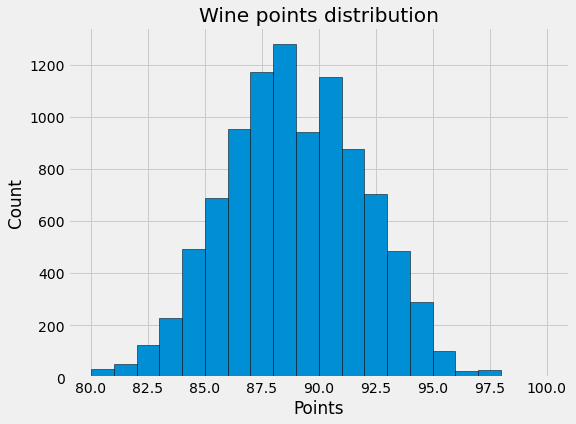

In [14]:
# Distribution of points
plt.style.use('fivethirtyeight')
plt.rc("figure", figsize=(8,6))
plt.hist(df['points'], bins = 20, edgecolor = 'k');
plt.xlabel('Points'); plt.ylabel('Count'); 
plt.title('Wine points distribution');

Visually, it is a normal distribution, since it has a bell-shaped curve.
Que tipo de observações eu posso tirar do fato de ser uma distribuição normal? Isso é bom ou ruim para o meu problema de regressão?
slightly to the left, which matches the market, since there are fewer good wines in the market. Also, the majority are of medium quality. 


PRICE

Is there a correlation between price and points? Is it true that higher qualities are more expensive? 
When plotting price vs points, we notice a slight upwards trend. 
Calculating the Pearson correlation tells us that the correlation is not a strong one, contrary to popular belief that more expensive products are always of better quality. 
The correlation is still significant enough for us to keep the features as an input to our model. 

It is interesting that since the majority of wines concentrates in prices below 200 dolars, when we change our subset to include only those wines, we can notice an even stronger correlation. Now of 0.51

points    1.00000
price     0.42163
dtype: float64

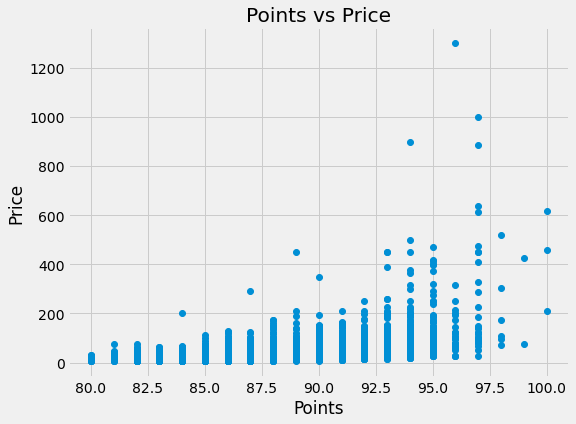

In [15]:
#plt.subplot(2, 2, 1)
#df_US = df.loc[df['country'] == 'US']
#plt.plot(df_US['points'], df_US['price'], 'o')
#plt.xlabel('Points'); plt.ylabel('Price'); 
#plt.title('Points vs Price in the US');
#df_US.corrwith(df_US['points'])

plt.plot(df['points'], df['price'], 'o')
plt.xlabel('Points'); plt.ylabel('Price'); 
plt.title('Points vs Price');
df.corrwith(df['points'])

points    1.000000
price     0.510577
dtype: float64

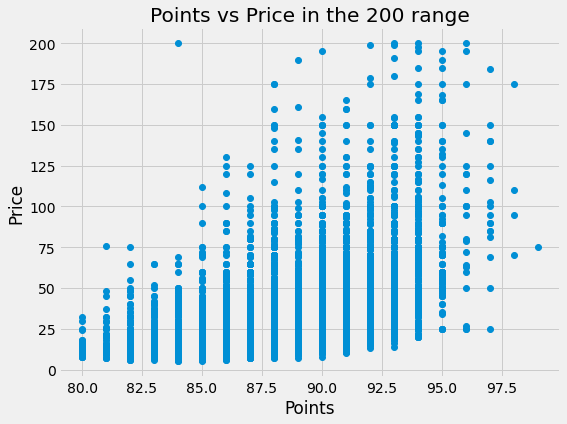

In [16]:
df_price200 = df.loc[df['price'] <= 200]
plt.plot(df_price200['points'], df_price200['price'], 'o')
plt.xlabel('Points'); plt.ylabel('Price'); 
plt.title('Points vs Price in the 200 range');
df_price200.corrwith(df_price200['points'])

COUNTRY

Are there countries that provide consistently better/worse wine? 

Wines in country 'orange' are slightly better than wines in country 'purple'. 
Some information can be extracted from the data. 

Now do the same for province, region and variety.
Always taking top 10, is this enough?
Do I have to vary the king of graph? Can I do the same thing even for taster name? 

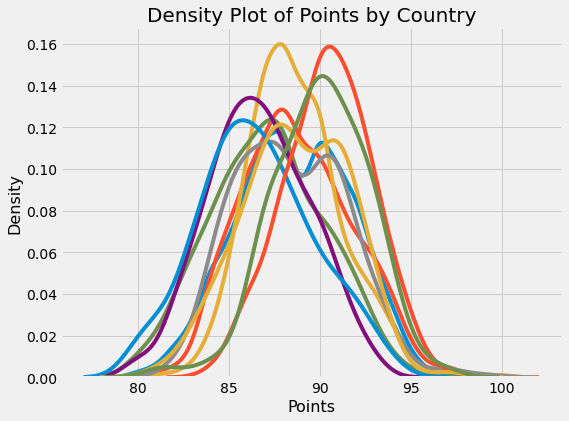

In [17]:
##### Tem que gerar essa lista automaticamente ######
countries = ['US', 'France', 'Italy', 'Spain', 'Portugal', 'Chile', 'Argentina', 'Austria', 'Australia', 'Germany']
#plt.figure(figsize=(8,6)
for country in countries:
    data = df.loc[df['country'] == country]
    sns.kdeplot(data['points'], label = country)

plt.xlabel('Points', size = 16); plt.ylabel('Density', size = 16); 
plt.title('Density Plot of Points by Country', size = 20);
#### Pq o label não pegou?####
#### Fazer um desses para Province, Region and Variety ####


FEATURE EXTRACTION

Here we are going to generate numerical features from textual ones. 
The ideia is to derive compound and description length from Description and year from Title.
Also, we are going to encode the categorical features.
The ideia is to try different forms of encoding. Start with the most simple one of giving a number to each unique value, then explaining why one hot enconding is not a good idea to the high cardinality features. End up with hashing encoder. 

Try random forest with full normal encoder, full hashing encoder and then a mixture of the two (or three - one hot).


In [18]:
df.corrwith(df['points'])

points    1.00000
price     0.42163
dtype: float64

In [14]:
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import category_encoders as ce
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [15]:
analyzerObj = SentimentIntensityAnalyzer()
sentence = df.iloc[8]['description']
score = analyzerObj.polarity_scores(sentence)
print(sentence)
print(score)

df['descLen'] = df['description'].map(lambda description: len(description))
df['posScore'] = df['description'].map(lambda description: analyzerObj.polarity_scores(description)['pos'])
df['neuScore'] = df['description'].map(lambda description: analyzerObj.polarity_scores(description)['neu'])
df['negScore'] = df['description'].map(lambda description: analyzerObj.polarity_scores(description)['neg'])
df['compound'] = df['description'].map(lambda description: analyzerObj.polarity_scores(description)['compound'])
df['year'] = df['title'].map(lambda title: re.search(r"(\d{4})", title).group(1) if re.search(r"(\d{4})", title) else '0')
df.to_csv("withCompound.csv")

Steel and nervy mineralogy are the hallmarks of this wine at this stage. It's still waiting for the fruit to develop, but expect crisp citrus and succulent apples. The aftertaste, tensely fresh now, should soften as the wine develops. This 90% Sauvignon Blanc and 10% Sémillon blend comes from the estate's small vineyard on the slope near Cadillac.
{'neg': 0.045, 'neu': 0.907, 'pos': 0.048, 'compound': 0.0387}


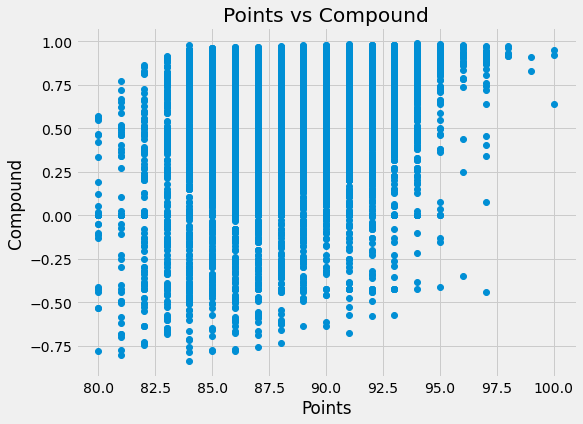

In [21]:
plt.plot(df['points'], df['compound'], 'o')
plt.xlabel('Points'); plt.ylabel('Compound'); 
plt.title('Points vs Compound');


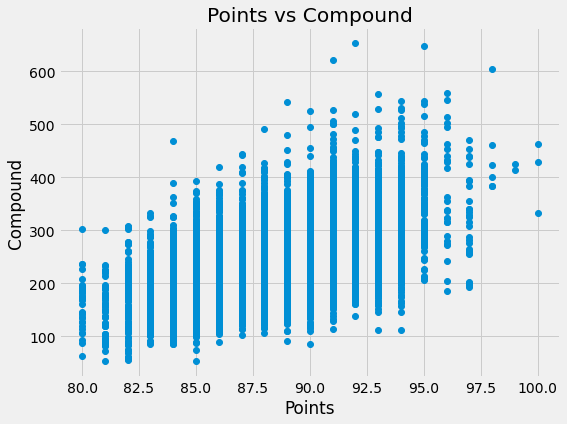

In [22]:
plt.plot(df['points'], df['descLen'], 'o')
plt.xlabel('Points'); plt.ylabel('Compound'); 
plt.title('Points vs Compound');

In [23]:
df.corrwith(df['points'])

points      1.000000
price       0.421630
descLen     0.552928
posScore    0.164912
neuScore   -0.103341
negScore   -0.183557
compound    0.319113
dtype: float64

In [24]:
#df.to_csv('withYear.csv')

In [25]:
#print("Missing values in each column")
#for column in df: 
#    print(column + " : " + str(df[column].isnull().sum()))

In [26]:
#df.to_csv('noNANs.csv')

In [27]:
#df['country'].value_counts()
#df['province'].value_counts()
#df['region1'].value_counts()
#df['tasterName'].unique()
#df['variety'].unique()
#df['winery'].unique()

In [28]:

#df = pd.get_dummies(df,columns=['variety'], drop_first = True)
#df.head()

In [29]:
columns = df.columns.values.tolist()
print(columns)

['country', 'description', 'points', 'price', 'province', 'region_1', 'taster_name', 'title', 'variety', 'descLen', 'posScore', 'neuScore', 'negScore', 'compound', 'year']


In [30]:
df.head()

,country,description,points,price,province,region_1,taster_name,title,variety,descLen,posScore,neuScore,negScore,compound,year
0,Italy,"Fragrances suggest hay, crushed tomato vine an...",90,30.0,Northeastern Italy,Alto Adige,Kerin O’Keefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon,222,0.382,0.575,0.044,0.9403,2012
1,France,"Packed with fruit and crisp acidity, this is a...",87,22.0,Loire Valley,Sancerre,Roger Voss,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé,174,0.091,0.909,0.000,0.4404,2014
3,US,Pretty in violet and rose petals this is a low...,92,50.0,California,Russian River Valley,Virginie Boone,Davis Family 2012 Horseshoe Bend Vineyard Pino...,Pinot Noir,268,0.113,0.887,0.000,0.6705,2012
4,US,This golden wine confounds in a mix of wet sto...,93,38.0,California,Russian River Valley,Virginie Boone,Dutton-Goldfield 2013 Dutton Ranch Chardonnay ...,Chardonnay,326,0.066,0.934,0.000,0.4404,2013
5,US,"This is a lush, rich Chardonnay with especiall...",84,14.0,California,Dry Creek Valley,0,Pedroncelli 2012 Signature Selection Chardonna...,Chardonnay,133,0.213,0.787,0.000,0.6908,2012


HASH ENCODER FOR CATEGORICAL FEATURES


Hashing Encoder para a coluna Country


Embedding -> 
Auto ML -> sklearn

In [24]:
X = df.drop(columns=['points', 'description', 'title', 'posScore', 'neuScore', 'negScore'])
y = df['points']


In [25]:
encoder = ce.HashingEncoder(cols = 'country')
X_country = encoder.fit_transform(X, y)

X_country.columns = [
    'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 'country_7',
    'price', 'province', 'region_1', 'taster_name', 'variety', 'descLen', 'compound', 'year'
]
X_country.head()


,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,price,province,region_1,taster_name,variety,descLen,compound,year
0,0,0,0,0,0,0,1,0,30.0,Northeastern Italy,Alto Adige,Kerin O’Keefe,Sauvignon,222,0.9403,2012
1,0,1,0,0,0,0,0,0,22.0,Loire Valley,Sancerre,Roger Voss,Rosé,174,0.4404,2014
2,0,0,1,0,0,0,0,0,50.0,California,Russian River Valley,Virginie Boone,Pinot Noir,268,0.6705,2012
3,0,0,1,0,0,0,0,0,38.0,California,Russian River Valley,Virginie Boone,Chardonnay,326,0.4404,2013
4,0,0,1,0,0,0,0,0,14.0,California,Dry Creek Valley,0,Chardonnay,133,0.6908,2012


In [26]:
encoder = ce.HashingEncoder(cols = 'province')
X_province = encoder.fit_transform(X_country, y)
X_province.columns = [
    'province_0', 'province_1', 'province_2', 'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
    'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 'country_7',
    'price', 'region_1', 'taster_name', 'variety', 'descLen', 'compound', 'year'
]
X_province.head()

,province_0,province_1,province_2,province_3,province_4,province_5,province_6,province_7,country_0,country_1,...,country_5,country_6,country_7,price,region_1,taster_name,variety,descLen,compound,year
0,0,0,0,0,0,0,0,1,0,0,...,0,1,0,30.0,Alto Adige,Kerin O’Keefe,Sauvignon,222,0.9403,2012
1,0,0,0,0,0,0,1,0,0,1,...,0,0,0,22.0,Sancerre,Roger Voss,Rosé,174,0.4404,2014
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,50.0,Russian River Valley,Virginie Boone,Pinot Noir,268,0.6705,2012
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,38.0,Russian River Valley,Virginie Boone,Chardonnay,326,0.4404,2013
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,14.0,Dry Creek Valley,0,Chardonnay,133,0.6908,2012


In [27]:
encoder = ce.HashingEncoder(cols = 'region_1')
X_region_1 = encoder.fit_transform(X_province, y)
X_region_1.columns = [
    'region_1_0', 'region_1_1', 'region_1_2', 'region_1_3', 'region_1_4', 'region_1_5', 'region_1_6', 'region_1_7',
    'province_0', 'province_1', 'province_2', 'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
    'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 'country_7',
    'price', 'taster_name', 'variety', 'descLen', 'compound', 'year'
]
X_region_1.head()

,region_1_0,region_1_1,region_1_2,region_1_3,region_1_4,region_1_5,region_1_6,region_1_7,province_0,province_1,...,country_4,country_5,country_6,country_7,price,taster_name,variety,descLen,compound,year
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,30.0,Kerin O’Keefe,Sauvignon,222,0.9403,2012
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,22.0,Roger Voss,Rosé,174,0.4404,2014
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,50.0,Virginie Boone,Pinot Noir,268,0.6705,2012
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,38.0,Virginie Boone,Chardonnay,326,0.4404,2013
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,14.0,0,Chardonnay,133,0.6908,2012


In [20]:
encoder = ce.HashingEncoder(cols = 'taster_name')
X_taster_name = encoder.fit_transform(X_region_1, y)
X_taster_name.columns = [
    'taster_name_0', 'taster_name_1', 'taster_name_2', 'taster_name_3', 'taster_name_4', 'taster_name_5', 'taster_name_6', 'taster_name_7',
    'region_1_0', 'region_1_1', 'region_1_2', 'region_1_3', 'region_1_4', 'region_1_5', 'region_1_6', 'region_1_7',
    'province_0', 'province_1', 'province_2', 'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
    'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 'country_7',
    'price', 'variety', 'descLen', 'compound', 'year'
]
X_taster_name.head()

,taster_name_0,taster_name_1,taster_name_2,taster_name_3,taster_name_4,taster_name_5,taster_name_6,taster_name_7,region_1_0,region_1_1,...,country_3,country_4,country_5,country_6,country_7,price,variety,descLen,compound,year
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,30.0,Sauvignon,222,0.9403,2012
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,22.0,Rosé,174,0.4404,2014
2,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,50.0,Pinot Noir,268,0.6705,2012
3,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,38.0,Chardonnay,326,0.4404,2013
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,14.0,Chardonnay,133,0.6908,2012


In [21]:
encoder = ce.HashingEncoder(cols = 'variety')
X_variety = encoder.fit_transform(X_taster_name, y)
X_variety.columns = [
    'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7', 
    'taster_name_0', 'taster_name_1', 'taster_name_2', 'taster_name_3', 'taster_name_4', 'taster_name_5', 'taster_name_6', 'taster_name_7',
    'region_1_0', 'region_1_1', 'region_1_2', 'region_1_3', 'region_1_4', 'region_1_5', 'region_1_6', 'region_1_7',
    'province_0', 'province_1', 'province_2', 'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
    'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 'country_7',
    'price', 'descLen', 'compound', 'year'
]
X_variety.head()

,variety_0,variety_1,variety_2,variety_3,variety_4,variety_5,variety_6,variety_7,taster_name_0,taster_name_1,...,country_2,country_3,country_4,country_5,country_6,country_7,price,descLen,compound,year
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,30.0,222,0.9403,2012
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,22.0,174,0.4404,2014
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,50.0,268,0.6705,2012
3,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,38.0,326,0.4404,2013
4,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,14.0,133,0.6908,2012


MODEL TRAINING AND EVALUATION

Training with all categorical features hash encoded gives an MSE of 3.78
We can see that the most important features are: price, description length, compound, year and taster name
Hash encoding causes loss of some explicability because we are not able to go back to the original tasters name as we could do with the one hot encoded metric. 
We could one hot encode just the taster name and see if this helps. 
To evaluate if this is a good classifier we need to: 
- Establish a baseline (naive classifier?)
- Show an example of a prediction
- Explain the MSE metric
- Plot random tree? 

RMSE.

Gradient Boost.
Shap Value para análise. 
Fazer regressão linear ou logística como base. 


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_variety, y, test_size=0.2) # 80% training and 20% test
clf=RandomForestRegressor()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("MSE:",metrics.mean_squared_error(y_test, y_pred))



MSE: 3.886940892579138


In [23]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': clf.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head()

,feature,importance
40,price,0.364729
41,descLen,0.243765
42,compound,0.122754
43,year,0.061018
10,taster_name_2,0.012525


Improvements: 
- Test different encoders
- Test different models
- Plot more graphs on EDA - specifically to show correlation between features that were engineered (compound, year, descLen)